In [28]:
! pip install tensorflow-gpu==1.14
! pip install stable-baselines

     |████████████████████████████████| 377.0MB 47kB/s 


In [29]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import namedtuple

In [30]:
# baseline imports
import gym
from gym import spaces
#from gym.envs.classic_control import rendering

In [31]:
from scipy.spatial.distance import euclidean
import numpy as np
from numpy.random import randint
from itertools import permutations
from random import shuffle

"""
Actions:
    -Draw vertex
    -Measure distance
    -Measure angle
"""
# DEFINE ENVIRONMENT
class GeometryEnvironment(gym.Env):
    """
    Custom environment implementing openAI gym interface
    """
    def __init__(self):
        # Define action and observation space
        # They must be gym.spaces objects

        # Example when using discrete actions:
        N_DISCRETE_ACTIONS = 9
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)

        # Example for using image as input:
        #self.observation_space = spaces.Box(low=0, high=255, shape=(HEIGHT, WIDTH, N_CHANNELS), dtype=np.uint8)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float64)
        self.reset()

        self.viewer = None

    def place_vertex(self, bead_index, vertex_index):
        self.bead_set[bead_index] = vertex_index

    def measure_distance(self, i, j):
        u = self.vertex_set[i]
        v = self.vertex_set[j]
        return euclidean(u, v)
    
    def reset(self, get_complex_reward = True):
        self.get_complex_reward = get_complex_reward
        self.bead_set = np.array([randint(0, 3) for i in range(2)])
        self.defining_state = (randint(low=0, high=100), randint(low=0, high=100))

        x = self.defining_state
        self.vertex_set = np.array([(0,0), (x[0],0), (0,x[1]), x])

        self.x_threshold = int(self.defining_state[0])
        self.y_threshold = int(self.defining_state[1])

        self.answer = 0
        self.correct_answer = np.sqrt(self.defining_state[0]**2 + self.defining_state[1]**2)
        self.measurement_made = False
        
        return self.get_state()
    
    def basic_reward(self):
        return -(np.abs(self.answer - self.correct_answer)**2)
    
    def complex_reward(self):
        return 10.0 if self.answer == self.correct_answer else 0.0
    
    def step(self, action_index):
        if (action_index == 8):
            # measure distance
            self.answer = self.measure_distance(self.bead_set[0], self.bead_set[1])
            self.measurement_made = True
        else:
            vertex_index = action_index % 4
            self.measurement_made = False
            if (action_index < 5):
                # move first bead
                self.place_vertex(0, vertex_index)
            else:
                # move other bead
                self.place_vertex(1, vertex_index)
        
        done = bool(self.answer == self.correct_answer)
        reward = self.complex_reward() if self.get_complex_reward else self.basic_reward()
        observations = self.get_state()
        info = {'time': "1"}

        return observations, reward, done, info
    
    def get_state(self):
        a = np.array(self.defining_state)
        b = np.array(self.vertex_set[(self.bead_set[0])])
        c = np.array(self.vertex_set[self.bead_set[1]])
        state = np.concatenate((a, b, c))
        #t_state = torch.tensor(nump, dtype=torch.long)
        return state.flatten()
    
    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold
        scale = screen_width/world_width

        polewidth = 10.0

        if self.viewer is None:
            self.viewer = rendering.Viewer(screen_width, screen_height)

            self.bead_0 = rendering.make_circle(polewidth/2)
            self.bead_0_trans = rendering.Transform()
            self.bead_0.add_attr(self.bead_0_trans)
            self.viewer.add_geom(self.bead_0)

            self.bead_1 = rendering.make_circle(polewidth/2)
            self.bead_1_trans = rendering.Transform()
            self.viewer.add_geom(self.bead_1)
            self.bead_1.add_attr(self.bead_1_trans)

        # Update viewer with current data
        beads = self.bead_set

        bead_0 = self.vertex_set[beads[0]]
        self.bead_0_trans.set_translation(bead_0[0], bead_0[1])

        bead_1 = self.vertex_set[beads[1]]
        self.bead_1_trans.set_translation(bead_1[0], bead_1[1])

        if (self.measurement_made):
            measurement_line = rendering.Line(start=bead_0, end=bead_1)
            self.viewer.add_geom(measurement_line)
        
        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

        #print("Answer: ", self.answer)
        vertices = np.array([self.vertex_set[(self.bead_set[0])], self.vertex_set[(self.bead_set[1])]])
        #print(vertices)
        x, y = vertices.T
        plt.scatter(x, y)
        plt.show()
    
    def set_state(self, x, y):
        self.defining_state = (int(x), int(y))
        x = self.defining_state
        self.vertex_set = np.array([(0,0), (x[0],0), (0,x[1]), x])
        self.answer = 0
        self.correct_answer = np.sqrt(self.defining_state[0]**2 + self.defining_state[1]**2)
    
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [32]:
import stable_baselines
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN

# Instantiate the env
env = GeometryEnvironment()

# Define and Train the agent
model = DQN(MlpPolicy, env, verbose=1, buffer_size=2000, gamma=0.25, double_q=False, batch_size=128, learning_starts=50, target_network_update_freq=10)

In [33]:
#from stable_baselines.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
#check_env(env)

In [34]:
"""
REFERENCE PARAMETERS
BATCH_SIZE = 128
GAMMA = 0.5 #0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 50
TARGET_UPDATE = 10
"""

'\nREFERENCE PARAMETERS\nBATCH_SIZE = 128\nGAMMA = 0.5 #0.999\nEPS_START = 0.9\nEPS_END = 0.05\nEPS_DECAY = 50\nTARGET_UPDATE = 10\n'

In [38]:
model.learn(total_timesteps=10000)

--------------------------------------
| % time spent exploring  | 25       |
| episodes                | 100      |
| mean 100 episode reward | 10       |
| steps                   | 756      |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 200      |
| mean 100 episode reward | 10       |
| steps                   | 1405     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 300      |
| mean 100 episode reward | 10       |
| steps                   | 2276     |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 400      |
| mean 100 episode reward | 10       |
| steps                   | 3592     |
--------------------------------------
--------------------------------------
| % time spent exploring 

In [39]:
# Test the trained agent
import time
test_states = []
test_actions = []

obs = env.reset()

n_steps = 50
for step in range(n_steps):
    test_states.append(obs)
    action, _ = model.predict(obs, deterministic=True)
    print("Step {}".format(step + 1))
    print("Action: ", action)
    obs, reward, done, info = env.step(action)
    print('obs=', obs, 'reward=', reward, 'done=', done)

    test_actions.append(action)

    #env.render()
    time.sleep(0.4)
    if done:
    # Note that the VecEnv resets automatically
    # when a done signal is encountered
        print("Goal reached!", "reward=", reward)
        break
#input()
#env.close()

Step 1
Action:  1
obs= [25 47 25  0  0 47] reward= 0.0 done= False
Step 2
Action:  8
obs= [25 47 25  0  0 47] reward= 10.0 done= True
Goal reached! reward= 10.0


In [40]:
import matplotlib.animation as animation
from IPython.display import HTML

measurements = np.array(test_actions) == 8
#=========================================
# Animate Images

fig = plt.figure(figsize=(10, 10))
ims = []
for i in range(len(test_states)):
    x = np.array(test_states[i])[2:5:2]
    y = np.array(test_states[i])[3:6:2]
    if (measurements[i]):
        ims.append([plt.scatter(x, y, animated=True)])
        im, = plt.plot(x, y, 'ro-', animated=True)
    else:
        im = plt.scatter(x, y, animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True, repeat_delay=1000)
plt.close()

# Show the animation
HTML(ani.to_jshtml())

In [57]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


def compute_steps(x_val, y_val, max_count=5):
        env.reset()
        env.set_state(x_val, y_val)
        obs = env.get_state()

        for t in count():
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            if done or t > max_count:
                return t
                

vectorized_steps = np.vectorize(compute_steps)


def test_range(x, y, max_count=100):
    X, Y = np.meshgrid(x, y)
    Z = vectorized_steps(X, Y)

    plt.pcolormesh(X, Y, Z)
    plt.colorbar()
    plt.show()

    optimal = Z < 3
    plt.pcolormesh(X, Y, optimal)
    plt.colorbar()
    plt.show()

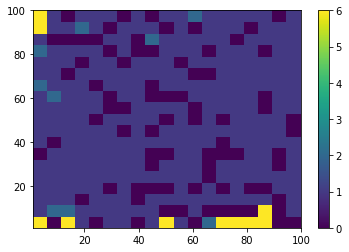

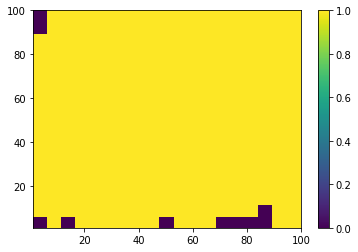

In [49]:
x_simple = y_simple = np.linspace(1, 100, 20)
test_range(x_simple, y_simple)

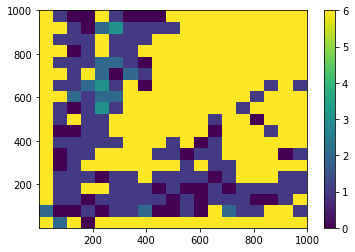

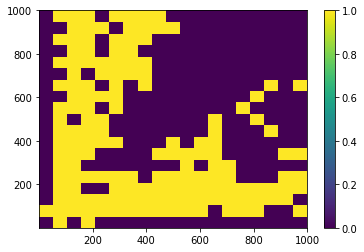

In [55]:
x_simple = y_simple = np.linspace(1, 1000, 20)
test_range(x_simple, y_simple)

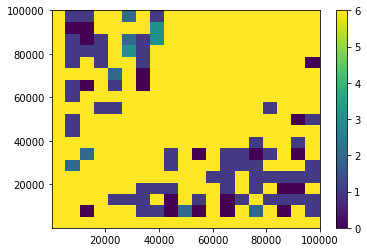

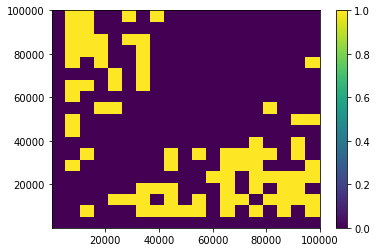

In [59]:
x_simple = y_simple = np.linspace(1, 100000, 20)
test_range(x_simple, y_simple, max_count=100)

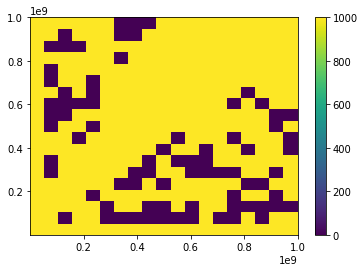

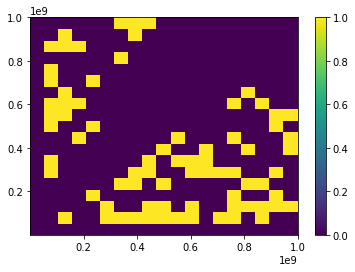

In [45]:
x_simple = y_simple = np.linspace(1, 1000000000, 20)
test_range(x_simple, y_simple)

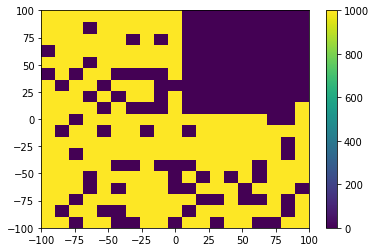

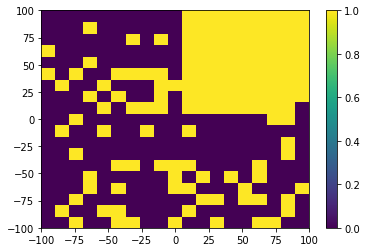

In [46]:
x_simple = y_simple = np.linspace(-100, 100, 20)
test_range(x_simple, y_simple)

In [47]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored